In [59]:
# Импорт необходимых библиотек.
import sqlite3
import os
import pandas as pd
import matplotlib.pyplot as plt

# Пути до файлов.
folder = os.getcwd()

sql_folder = fr'{folder}\SQL'

files_folder = fr'{folder}\files'
if not os.path.exists(files_folder):
    os.mkdir(files_folder)

db = fr'{folder}\db\testDB.sqlite3'

# Создание подключения к БД.
conn = sqlite3.connect(db)


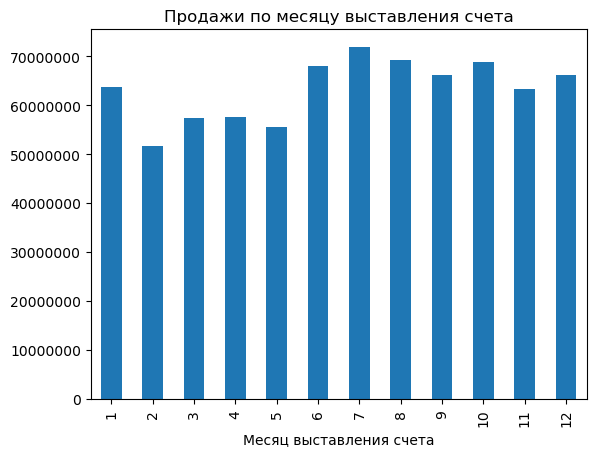

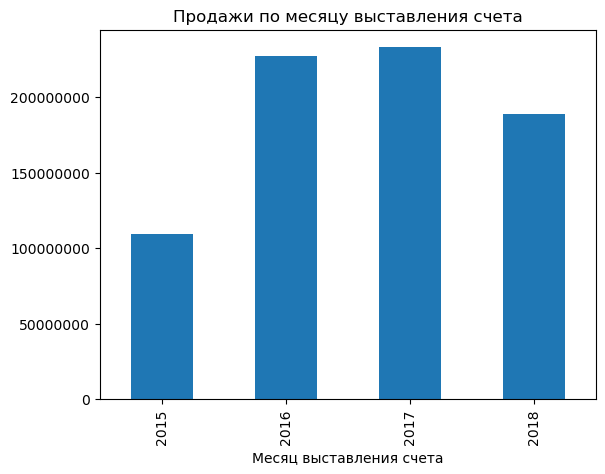

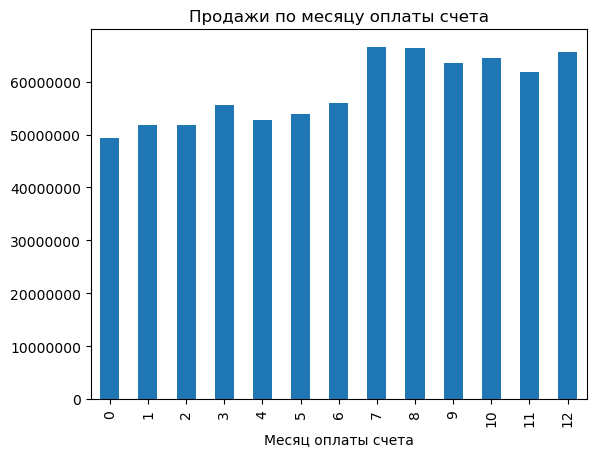

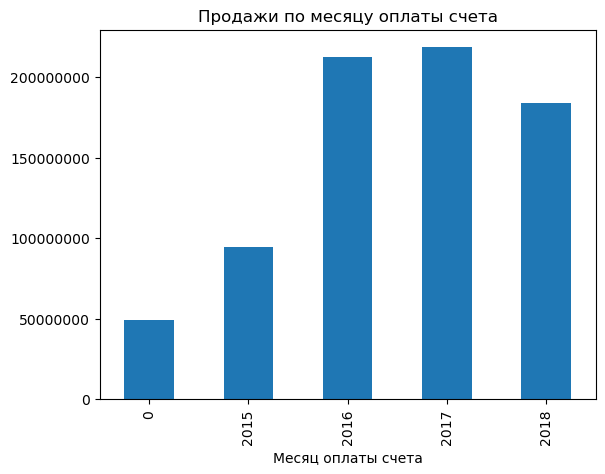

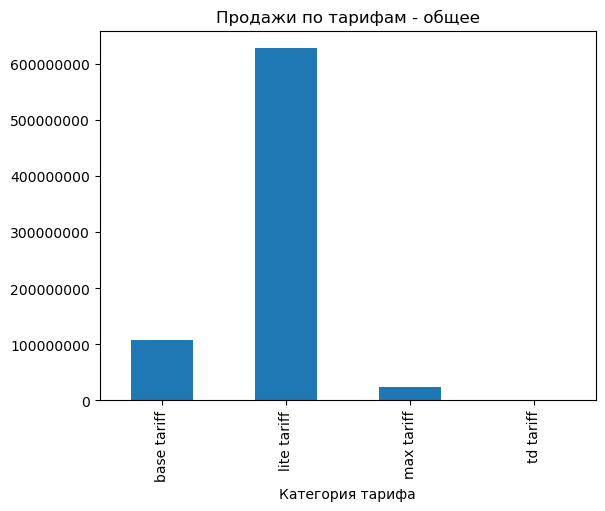

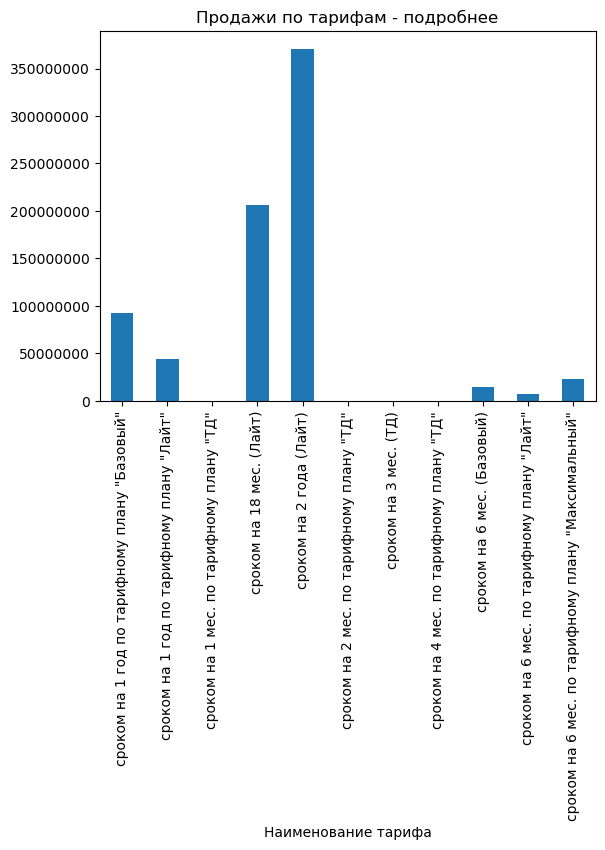

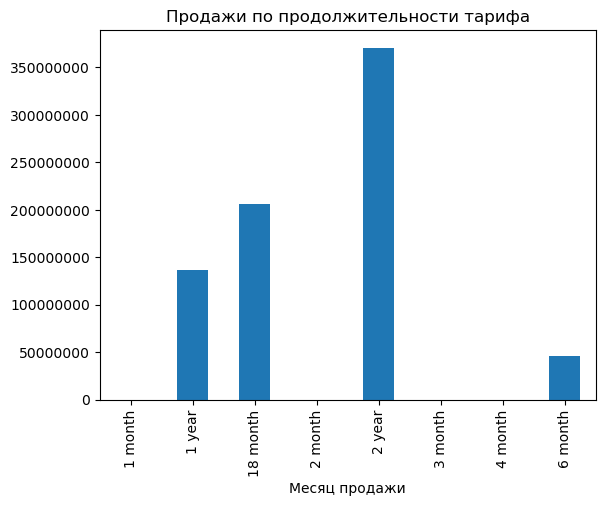

In [88]:
# Функция для сокращения наименования тарифа.
# Берем строку, начиная с "сроком на...".
def clear_name(string):
    temp = string.split()
    return ' '.join(temp[4:])


# Функция для получения укрупненной категории наименования тарифа.
def tariff_name(string):
    if 'Лайт' in string:
        return 'lite tariff'
    elif 'Базовый' in string:
        return 'base tariff'
    elif 'ТД' in string:
        return 'td tariff'
    elif 'Максимальный' in string:
        return 'max tariff'
    else:
        return 'unknown tariff'


# Функция для получения продолжительности тарифа.
def tariff_duration(string):
    if 'на 6 мес.' in string:
        return '6 month'
    elif 'на 1 год' in string:
        return '1 year'
    elif 'на 1 мес.' in string:
        return '1 month'
    elif 'на 18 мес.' in string:
        return '18 month'
    elif 'на 2 года' in string:
        return '2 year'
    elif 'на 2 мес.' in string:
        return '2 month'
    elif 'на 3 мес.' in string:
        return '3 month'
    elif 'на 4 мес.' in string:
        return '4 month'
    else:
        return 'unknown duration'


# SQL запрос для получения продаж из таблицы "Счета".
# Считаю, что, если есть оплаченный счет, то была подтвержденная продажа.
# Сам SQL запрос можно посмотреть в соответствующей папке.
# Берем только одну категорию продукта - "Бухгалтерия.Контур".
sql_sales = fr'{sql_folder}\sales.sql'
sales = open(sql_sales).read()

# Создаем датафрейм, помещаем в него результат выполнения SQL запроса.
df_sales = pd.read_sql_query(sales, conn)
# Преобразуем дату выставления счета и оплаты счета в тип "дата".
df_sales[['BDate', 'PayDate']] = df_sales[['BDate', 'PayDate']].apply(pd.to_datetime)

# Выделяем из даты выставления счета соответствующий месяц для анализа.
df_sales['month_bill'] = df_sales['BDate'].dt.month

# Выделяем из даты выставления счета соответствующий месяц для анализа.
df_sales['year_bill'] = df_sales['BDate'].dt.year

# Выделяем из даты оплаты счета соответствующий месяц для анализа.
# Заменяем пустые значения на 0.
# Преобразуем к типу "int".
df_sales['month_pay'] = df_sales['PayDate'].dt.month
df_sales['month_pay'].fillna(0, inplace=True)
df_sales['month_pay'] = df_sales['month_pay'].astype('int64')

# Выделяем из даты оплаты счета соответствующий месяц для анализа.
# Заменяем пустые значения на 0.
# Преобразуем к типу "int".
df_sales['year_pay'] = df_sales['PayDate'].dt.year
df_sales['year_pay'].fillna(0, inplace=True)
df_sales['year_pay'] = df_sales['year_pay'].astype('int64')

# Создаем новый стобец с сокращенным наименованием тарифа.
df_sales['new_name'] = df_sales['piName'].apply(clear_name)

# Создаем новый столбец с категорией тарифа.
df_sales['tariff_name'] = df_sales['new_name'].apply(tariff_name)

# Создаем новыйц столбец с продолжительностью тарифа.
df_sales['tariff_duration'] = df_sales['new_name'].apply(tariff_duration)

# Запишем датафрейм в csv для анализа либо для построения дашбордов в других системах.
df_sales.to_csv(fr'{files_folder}\sales.csv', index=False, sep=';', encoding='utf-8')

df_sum_by_bill_month = df_sales[['Cost', 'month_bill']].groupby('month_bill')['Cost'].agg('sum')
df_sum_by_bill_year = df_sales[['Cost', 'year_bill']].groupby('year_bill')['Cost'].agg('sum')

df_pay_sum_by_month = df_sales[['Cost', 'month_pay']].groupby('month_pay')['Cost'].agg('sum')
df_pay_sum_by_year = df_sales[['Cost', 'year_pay']].groupby('year_pay')['Cost'].agg('sum')

df_pay_sum_by_name = df_sales[['Cost', 'new_name']].groupby('new_name')['Cost'].agg('sum')
df_pay_sum_by_tariff_name = df_sales[['Cost', 'tariff_name']].groupby('tariff_name')['Cost'].agg('sum')
df_pay_sum_by_tariff_duration = df_sales[['Cost', 'tariff_duration']].groupby('tariff_duration')['Cost'].agg('sum')

df_sum_by_bill_month.plot(kind = 'bar')
plt.title('Продажи по месяцу выставления счета')
plt.ticklabel_format(style = 'plain', axis='y')
plt.xlabel('Месяц выставления счета', horizontalalignment='center')
plt.show()

df_sum_by_bill_year.plot(kind = 'bar')
plt.title('Продажи по месяцу выставления счета')
plt.ticklabel_format(style = 'plain', axis='y')
plt.xlabel('Месяц выставления счета', horizontalalignment='center')
plt.show()

df_pay_sum_by_month.plot(kind = 'bar')
plt.title('Продажи по месяцу оплаты счета')
plt.ticklabel_format(style = 'plain', axis='y')
plt.xlabel('Месяц оплаты счета', horizontalalignment='center')
plt.show()

df_pay_sum_by_year.plot(kind = 'bar')
plt.title('Продажи по месяцу оплаты счета')
plt.ticklabel_format(style = 'plain', axis='y')
plt.xlabel('Месяц оплаты счета', horizontalalignment='center')
plt.show()

df_pay_sum_by_tariff_name.plot(kind = 'bar')
plt.title('Продажи по тарифам - общее')
plt.ticklabel_format(style = 'plain', axis='y')
plt.xlabel('Категория тарифа', horizontalalignment='center')
plt.show()

df_pay_sum_by_name.plot(kind = 'bar')
plt.title('Продажи по тарифам - подробнее')
plt.ticklabel_format(style = 'plain', axis='y')
plt.xlabel('Наименование тарифа', horizontalalignment='center')
plt.show()

df_pay_sum_by_tariff_duration.plot(kind = 'bar')
plt.title('Продажи по продолжительности тарифа')
plt.ticklabel_format(style = 'plain', axis='y')
plt.xlabel('Месяц продажи', horizontalalignment='center')
plt.show()
